In [3]:
import poisson_atac as patac
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

Global seed set to 0


In [1]:
5

5

In [4]:
sns.set_style("whitegrid")

In [5]:
fig_path = '/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/Figure1'

In [6]:
def plot_df(df, figsize=(15, 8), xlabel="Number of reads"):
    df["color"]= df["#reads"]>0
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.barplot(data=df, x = '#reads', y = 'count', hue="color", palette="Paired", ax = ax, dodge=False)
    g.set_yscale('log')
    labels = g.get_xticklabels()
    labels[1::2] = np.repeat('', len(labels[1::2]))
    g.set_xticklabels(labels, rotation=90);
    g.legend().set_visible(False)
    g.grid(False)
    plt.xlabel(xlabel)
    plt.tight_layout()

In [7]:
def mean_var_scatter(df, label=r"$\sigma^2=\mu$", endpoint=(1,1), linestyle="solid"):
    fig, ax = plt.subplots(figsize=(6,6))
    g=sns.scatterplot(data=df, x="mean", y ="variance")
    g.set_yscale('log')
    g.set_xscale('log')
    
    if isinstance(label, list):
        for i, l in enumerate(label):
            g.axline((0,0), endpoint[i], color='darkgrey', linestyle=linestyle[i], label=l)
    else:
        g.axline((0,0), endpoint, color='darkgrey', linestyle=linestyle, label=label)
    g.grid(":", color="lightgrey")
    plt.xlabel(r"mean $\mu$")
    plt.ylabel(r"variance $\sigma^2$")
    plt.legend()
    plt.tight_layout()

In [8]:
def plot_mean_variance(adata, save_path=None, prefix=""):

    # number of counts
    X = np.ceil(adata.layers["counts"].A/2)
    mean_counts = X.mean(axis = 0)
    var_counts = X.var(axis = 0)
    df = pd.DataFrame({'mean': mean_counts, 'variance': var_counts})
    
    mean_var_scatter(df, label="Shot noise limit", endpoint=(1,1))
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_scatter.png"))
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_scatter.pdf"))
    
    X = adata.layers["counts"].A
    mean_counts = X.mean(axis = 0)
    var_counts = X.var(axis = 0)
    df = pd.DataFrame({'mean': mean_counts, 'variance': var_counts})
    
    mean_var_scatter(df, label=["Shot noise limit", r"$\sigma^2=2\mu$"], endpoint=[(1,1),(1,2)], linestyle=["solid", ":"])
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_scatter.png"))
        lt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_scatter.pdf"))

In [9]:
5

5

In [10]:
def plot_dataset(adata, save_path=None, prefix=None, limit=None):
    counts = pd.Series(adata.layers["counts"].data).value_counts().to_frame().reset_index().rename({0: 'count', 'index':'#reads'}, axis = 1)
    sns_df = pd.concat([counts, pd.DataFrame({'#reads':0.0 , 'count':adata.shape[0]*adata.shape[1]-len(adata.layers["counts"].data) }, index=[0])])
    sns_df['#reads'] = pd.Categorical(sns_df['#reads'].astype(int), categories=np.arange(sns_df['#reads'].max() + 1).astype(int), ordered=True)

    ## Plot all raw counts

    plot_df(sns_df, figsize = (40,8))
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_dist.pdf"))
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_dist.png"))
    
    ## Plot all raw counts in a range of 0-80
    if limit:
        sns_df = sns_df[sns_df['#reads']<=limit]
        sns_df["#reads"].cat.set_categories(np.arange(limit).astype(int), inplace=True)

    plot_df(sns_df, figsize = (10,4))
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_dist_zoom.pdf"))
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_raw_data_dist_zoom.png"))
    ## Convert counts

    data = np.ceil(adata.layers["counts"].data/2)

    counts = pd.Series(data).value_counts().to_frame().reset_index().rename({0: 'count', 'index':'#reads'}, axis = 1)
    sns_df = pd.concat([counts, pd.DataFrame({'#reads':0.0 , 'count':adata.shape[0]*adata.shape[1]-len(adata.layers["counts"].data) }, index=[0])])
    sns_df['#reads'] = pd.Categorical(sns_df['#reads'].astype(int), categories=np.arange(sns_df['#reads'].max() + 1).astype(int), ordered=True)

    plot_df(sns_df, figsize = (40,8), xlabel="Number of fragments")
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_dist.pdf"))
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_dist.png"))
    ## Plot all raw counts in a range of 0-80
    if limit:
        sns_df = sns_df[sns_df['#reads']<=limit]
        sns_df["#reads"].cat.set_categories(np.arange(limit).astype(int), inplace=True)

    plot_df(sns_df, figsize = (10,4), xlabel="Number of fragments")
    if save_path:
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_dist_zoom.pdf"))
        plt.gcf().savefig(os.path.join(save_path, f"{prefix}_transformed_data_dist_zoom.png"))

In [45]:
def plot_proportions(adata, figsize, fontsize, save_path=None, prefix="", lower_limit=0, upper_limit=2):
    
    # From scvelo https://github.com/theislab/scvelo/blob/master/scvelo/plotting/proportions.py
    counts = pd.Series(adata.layers["counts"].data).value_counts().to_frame().reset_index().rename({0: 'count', 'index':'reads'}, axis = 1)
    counts = pd.concat([counts, pd.DataFrame({'reads': 0.0 , 'count':adata.shape[0]*adata.shape[1]-len(adata.layers["counts"].data) }, index=[0])])
    counts["reads"] = counts["reads"].astype(int)
    
    sns_df = pd.concat([counts[(counts["reads"] <= upper_limit) & (counts["reads"] > lower_limit)], pd.DataFrame({'reads': f">{upper_limit}", "count": counts["count"][counts["reads"]>upper_limit].sum()}, index =[0])])
    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    colors = sns.color_palette("Paired", sns_df.shape[0], as_cmap=False)
    autopct = "%1.1f%%" 
    #explode=(0, 0.1, 0.1, 0.1)
    explode=None
    pie = ax.pie(
        sns_df["count"],
        colors=colors,
        explode=explode,
        autopct=autopct,
        shadow=False,
        startangle=45,
        textprops={'size': 'smaller'}
    )
    if autopct is not None:
        for pct, color in zip(pie[-1], colors):
            r, g, b = color
            pct.set_color("black" if r * g * b < 0.5 else "darkgrey")
            #plt.setp(pct, size='large')
            #pct.set_fontweight("bold")
            pct.set_fontsize(fontsize)
    ax.legend(
        sns_df["reads"].astype(str) + " read(s)",
        ncol=len(sns_df["reads"]),
        bbox_to_anchor=(0, 1),
        loc="lower left",
        fontsize=fontsize,
    )
    if save_path:
        fig.savefig(os.path.join(save_path, f"{prefix}_proportions.png"))
        fig.savefig(os.path.join(save_path, f"{prefix}_proportions.pdf"))

# Neurips

In [12]:
adata = patac.data.load_neurips(only_train=False, convert_counts = False)

In [14]:
adata

AnnData object with n_obs × n_vars = 62501 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train', 'size_factor'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_13436/2297418916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"]= df["#reads"]>0
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories w

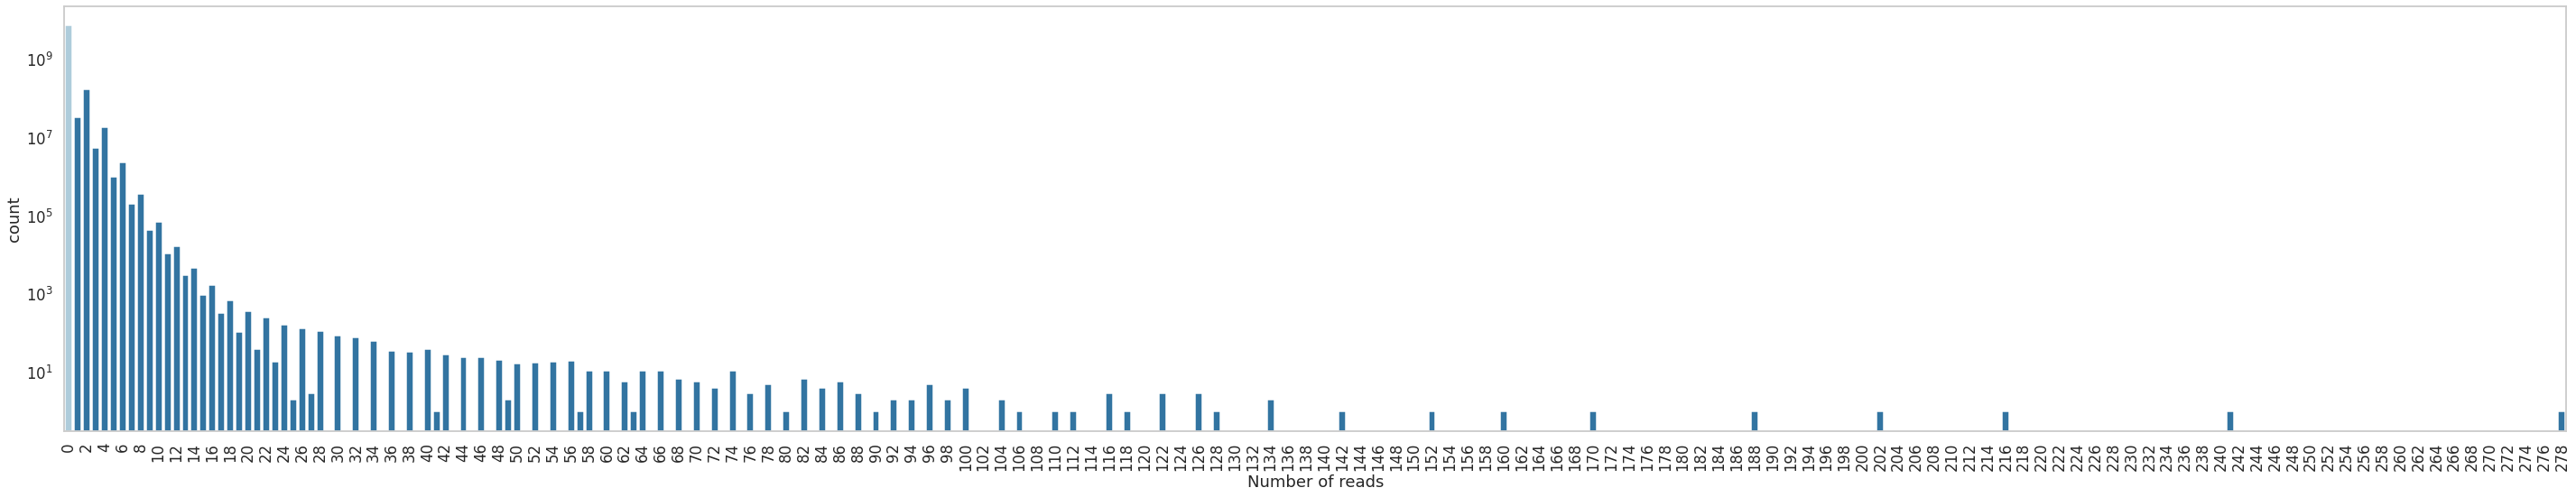

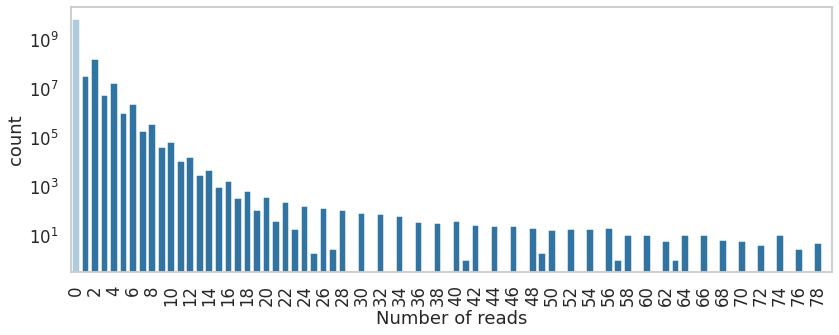

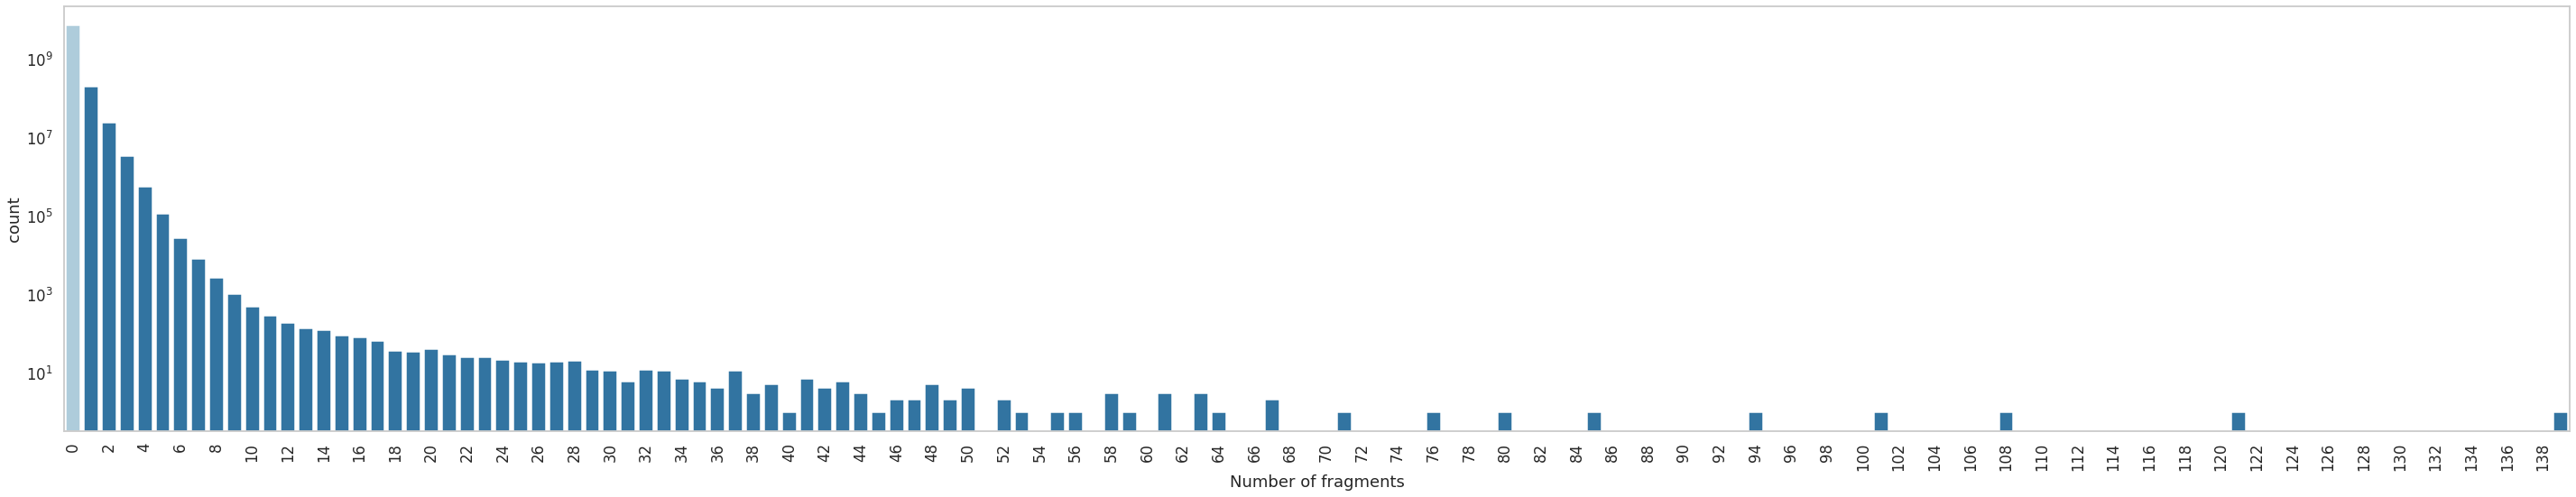

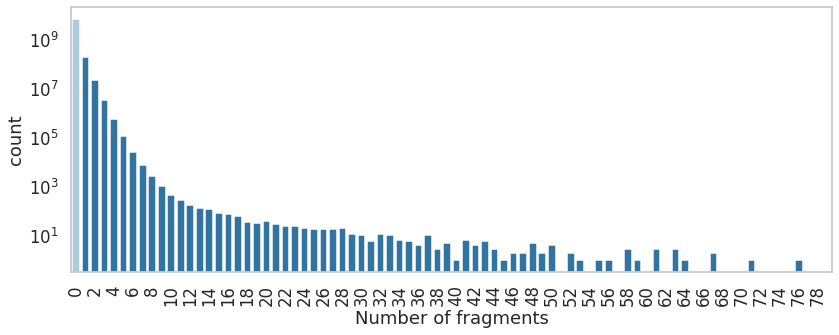

In [48]:
plot_dataset(adata, save_path=fig_path, prefix="neurips", limit=80)

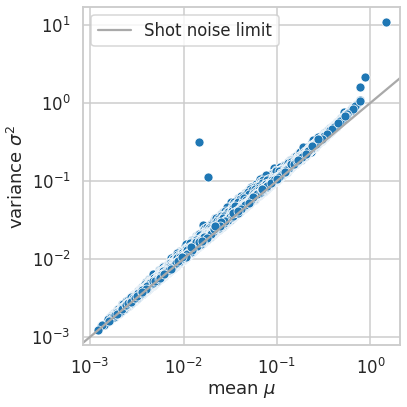

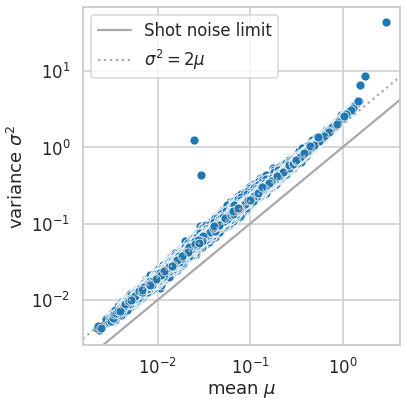

In [156]:
plot_mean_variance(adata, save_path=fig_path, prefix="neurips")

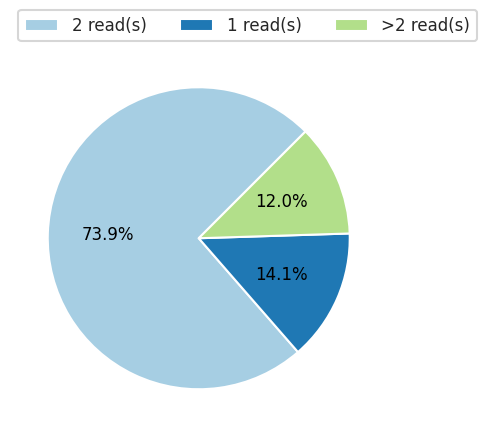

In [47]:
plot_proportions(adata, figsize=(5,5), fontsize=12) #, save_path=fig_path, prefix="neurips"

# Hematopoeisis

In [158]:
adata = patac.data.load_hematopoiesis(convert_counts = False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


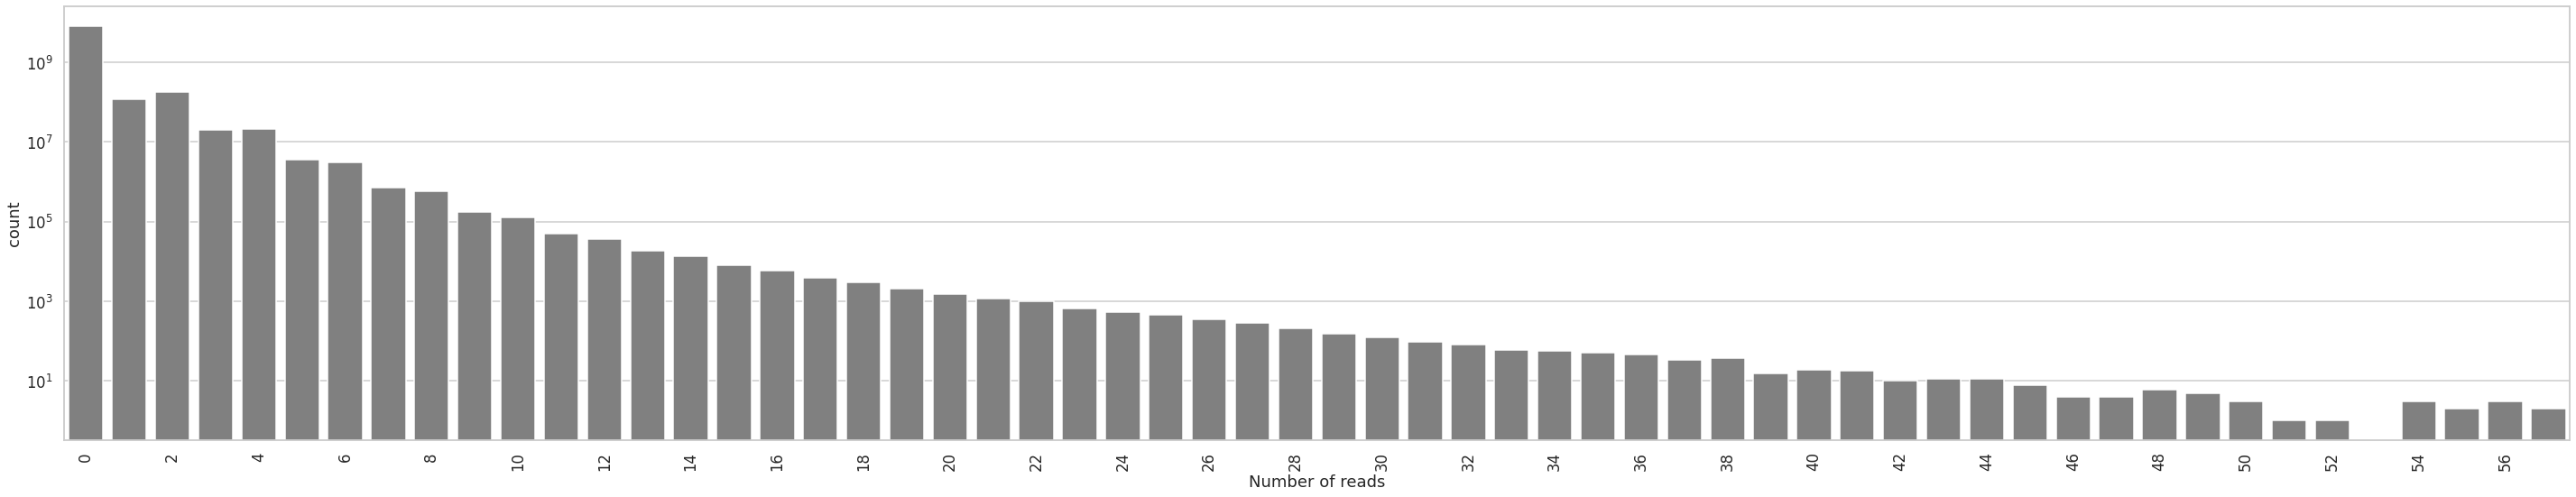

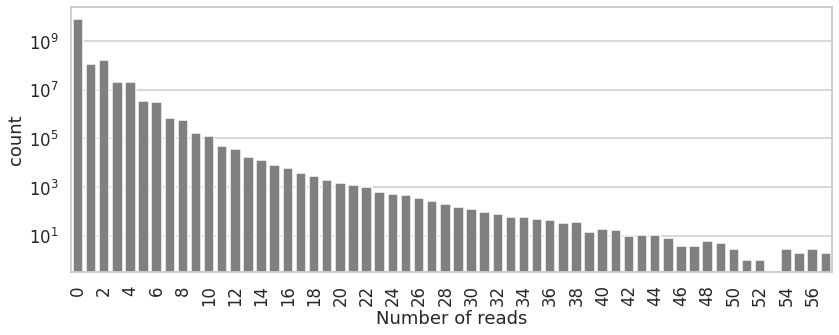

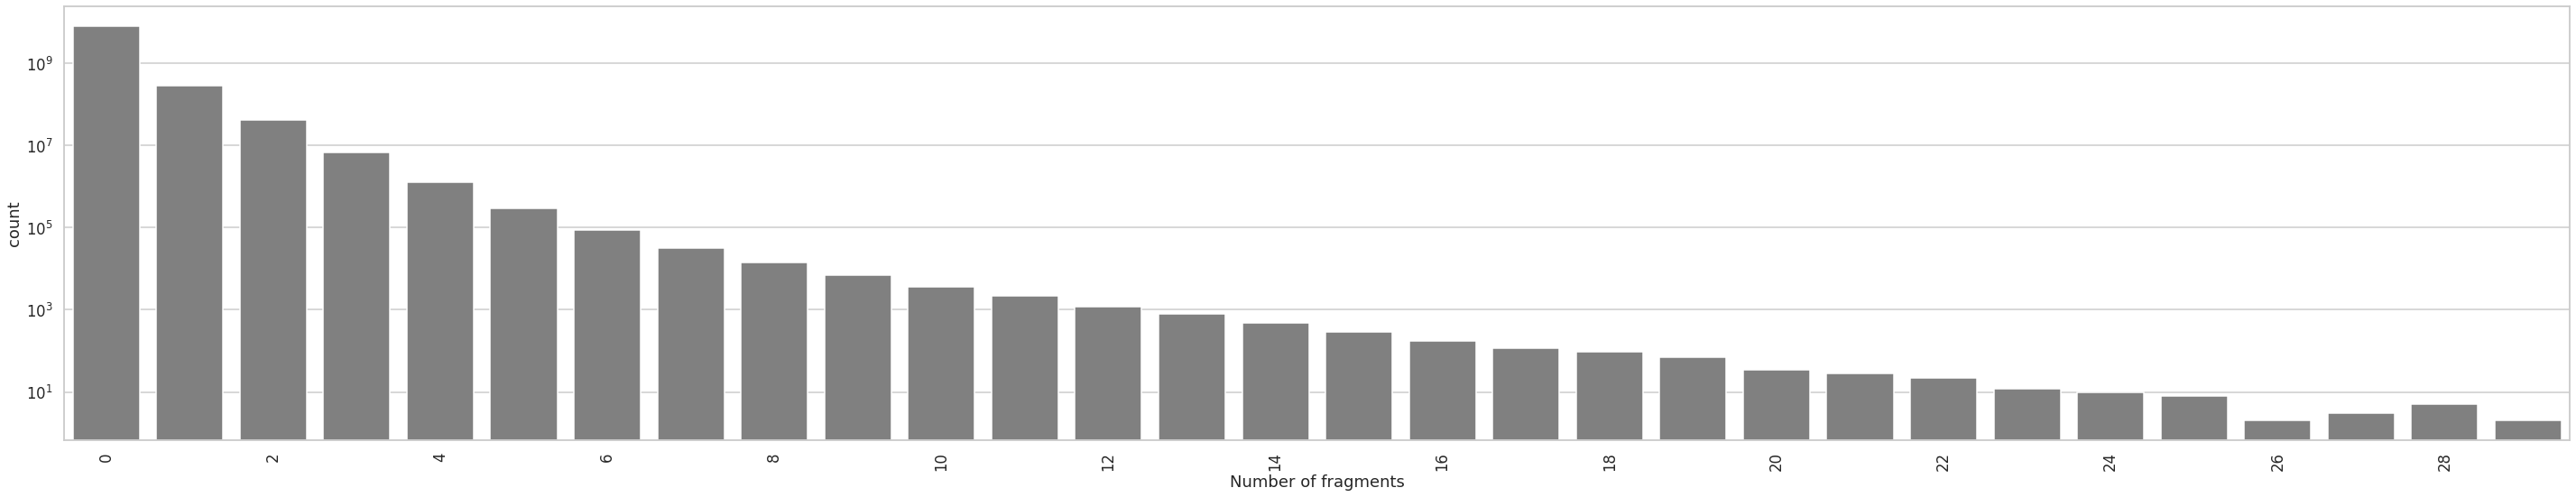

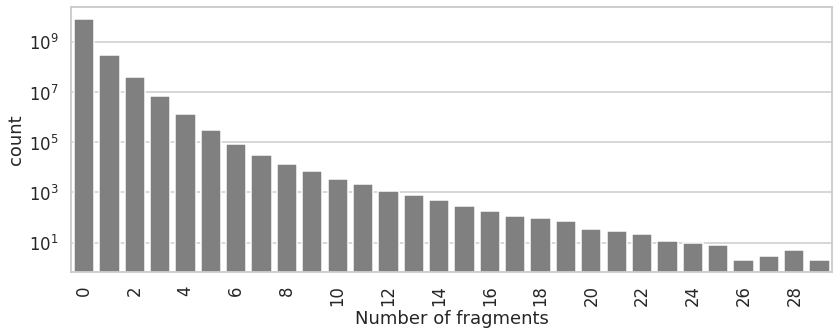

In [169]:
plot_dataset(adata, save_path=fig_path, prefix="hematopoiesis", limit=None)

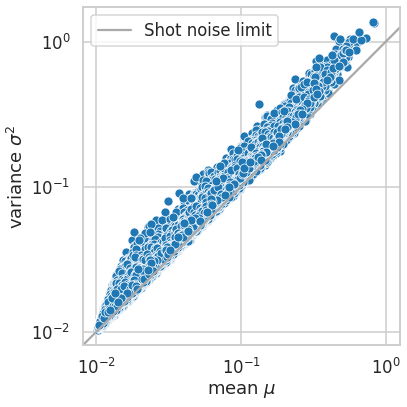

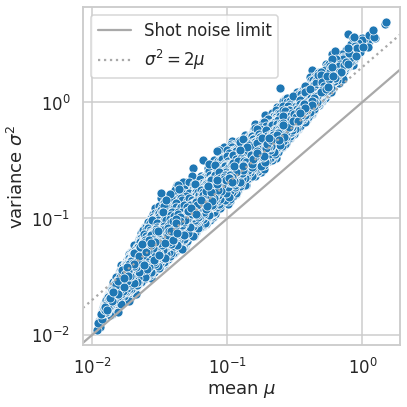

In [159]:
plot_mean_variance(adata, save_path=fig_path, prefix="hematopoiesis")

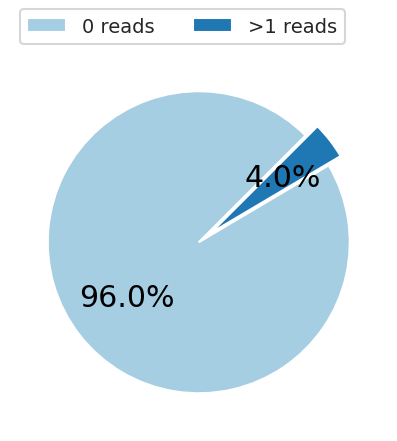

In [160]:
plot_proportions(adata, figsize=(5,5), fontsize=14, save_path=fig_path, prefix="hematopoiesis")